In [1]:
import numpy as np
from scipy.sparse import linalg as linalg
from scipy.sparse import lil_matrix as lil_matrix
import cv2
from matplotlib import pyplot as plt


# code for different areas in pictire
MASK = 0                 
BOUNDRY = 1
OUTSIDE = 2

def in_mask(location, mask):
    '''
    A function to check if the input location is in the mask region.

    Args:
    location: ndarray (x,y) the location on a image
    mask: ndarray image that represents for mask. 1 for mask region and 0 for unmask region

    Returns
    A bool value 
    True if location in the mask region
    '''
    if mask[location] == 1:
        return True
    elif mask[location] == 0:
        return False
    else:
        return "Please first normalize mask!"

def get_nearby_locations(location):
    '''
    Get the four nearby locations around the input location

    Args:
    location: ndarray with two element

    Return:
    A list contains four tuples 
    '''
    x, y = location
    nearby = [(x+1, y), (x-1, y), (x, y+1), (x, y-1)]
    return nearby


def in_boundry(location, mask):
    '''
    A function to detect if the location is on the boundry of mask
    Noted that we define "the boundry of mask" is in the mask
    '''
    if in_mask(location, mask) == False:
        return False
    else:
        for nearby_location in get_nearby_locations(location):
            if in_mask(nearby_location, mask) == False:
                return True
        
        return False
    

def point_location(location, mask):
    '''
    Detect what region s.t. the input location belong to 
    '''
    if in_mask(location,mask) == False:
        return OUTSIDE
    if in_boundry(location,mask) == True:
        return BOUNDRY
    return MASK


def Laplacian(source, location):
    '''
    Apply Laplacian operator to the location on the source image 
    '''
    x, y = location
    value = (4 * source[x,y])- (1 * source[x+1, y]) - (1 * source[x-1, y]) - (1 * source[x, y+1]) - (1 * source[x, y-1])
    return value


def mask_location(mask):
    '''
    Get all location that in the mask region
    '''
    x, y = np.nonzero(mask)
    return list(zip(x, y))



# Create the A sparse matrix
def poisson_sparse_matrix(points):
    '''
    Create a sparse A matrix 
    '''
    # N = number of points in mask
    N = len(points)
    A = lil_matrix((N,N))
    # Set up row for each point in mask
    for i,index in enumerate(points):
        # Should have 4's diagonal
        A[i,i] = 4
        # Get all surrounding points
        for x in get_nearby_locations(index):
            # If a surrounding point is in the mask, add -1 to index's
            # row at correct position
            if x not in points: 
                continue
            j = points.index(x)
            A[i,j] = -1
    return A

# Main method
# Does Poisson image editing on one channel given a source, target, and mask
def process(source, target, mask):
    locations = mask_location(mask)
    N = len(locations)
    # Create poisson A matrix. Contains mostly 0's, some 4's and -1's
    A = poisson_sparse_matrix(locations)
    # Create B matrix
    b = np.zeros(N)
    for i,location in enumerate(locations):
        # Start with left hand side of discrete equation
        b[i] = Laplacian(source, location)
        # If on boundry, add in target intensity
        # Creates constraint lapl source = target at boundary
        if point_location(location, mask) == BOUNDRY:
            for pt in get_nearby_locations(location):
                if in_mask(pt,mask) == False:
                    b[i] += target[pt]

    # Solve for x, unknown intensities
    x = linalg.cg(A, b)
    # Copy target photo, make sure as int
    composite = np.copy(target).astype(int)
    # Place new intensity on target at given index
    for i,location in enumerate(locations):
        composite[location] = x[0][i]
    return composite


def normalize_mask(mask_img):
    # Normalize mask to range [0,1]
    mask = np.atleast_3d(mask_img).astype(np.float64) / 255.
    # Make mask binary
    mask[mask != 1] = 0
    # Trim to one channel
    mask = mask[:,:,0]

    return mask


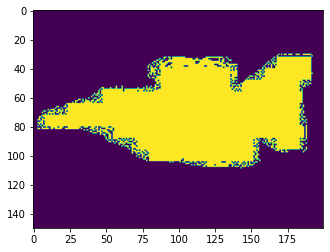

In [2]:
source_img = cv2.imread("input/2/source.jpg")
target_img = cv2.imread("input/2/target.jpg")
mask_img = cv2.imread("input/2/mask.jpg", cv2.IMREAD_GRAYSCALE)

# cv2 read image in the order BGR
# plt show the image in the order of RGB
# Therefore we need following steps to transform 
target_img = cv2.cvtColor(target_img, cv2.COLOR_BGR2RGB)
source_img = cv2.cvtColor(source_img, cv2.COLOR_BGR2RGB)

mask = normalize_mask(mask_img)
plt.imshow(mask)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


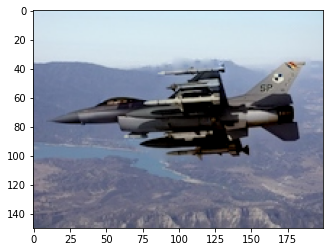

In [3]:
source_img = cv2.imread("input/2/source.jpg")
target_img = cv2.imread("input/2/target.jpg")
mask_img = cv2.imread("input/2/mask.jpg", cv2.IMREAD_GRAYSCALE)

# cv2 read image in the order BGR
# plt show the image in the order of RGB
# Therefore we need following steps to transform 
target_img = cv2.cvtColor(target_img, cv2.COLOR_BGR2RGB)
source_img = cv2.cvtColor(source_img, cv2.COLOR_BGR2RGB)

mask = normalize_mask(mask_img)
num_channels = source_img.shape[-1]

temp = []
for i in range(num_channels):
    result = process(source_img[:,:,i], target_img[:,:,i], mask)
    temp.append(result)
# Merge the channels back into one image
result = cv2.merge((temp[0], temp[1], temp[2]))

# Write result
plt.imshow(result)
